# Measure General SAE Metrics

## Imports

In [1]:
import torch
import numpy as np

import overcomplete

from src import losses, train, metrics
from src.utils import (
    get_coco, get_laion, get_imagenet,
    _train,
    measure_everything, measure_bridge, get_bridge_norms,
    get_rho,
)
from src.utils import (
    plot_energy, plot_energy_cdf, plot_E_vs_E_B,
    plot_modality_energy, mu_vs_mu_B,
    plot_bridges,
)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Definitions

In [2]:
use_model = "clip"  # openclip or siglip

In [3]:
if use_model == "clip":
    model_name = "openai/clip-vit-base-patch32"
    d_model = 512
    beta = 4e-4
elif use_model == "clip-L":
    model_name = "openai/clip-vit-large-patch14"
    d_model = 768
    beta = 1e-4
elif use_model == "openclip":
    model_name="laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
    d_model = 512
    beta = 4e-4
elif use_model == "openclip-L":
    model_name="laion/CLIP-ViT-L-14-laion2B-s32B-b82K"
    d_model = 768
    beta = 2e-4
elif use_model == "siglip":
    model_name = "google/siglip-base-patch16-224"
    d_model = 768
    beta = 1e-4
elif use_model == "siglip2":
    model_name = "google/siglip2-base-patch16-224"
    d_model = 768
    beta = 7e-5
else:
    raise NotImplementedError(f"Model {use_model} not recognized.")

In [4]:
laion_loader = get_laion(device=device, model_name=model_name)
# coco_loader = get_coco(device=device)
# imagenet_test_loader, class_embeddings = get_imagenet(batch_size=512, model_name=model_name, device=device)
# imagenet_train_loader, class_embeddings = get_imagenet(batch_size=512, model_name=model_name, device=device, split="train")

train_loader = laion_loader

Resolving data files:   0%|          | 0/128 [00:00<?, ?it/s]

In [5]:
modality_threshold = 0.05

In [6]:
SSAE, SSAE_name, _ = _train(beta=1e-4, train_loader=train_loader, model_name=model_name, d_model=d_model, archi="MP", device=device, expansion_factor=64, top_k=50) #, force_retrain=True, save_quand_meme=True) # Standard SAE
# ASAE, ASAE_name, _ = _train(beta=beta, train_loader=train_loader, model_name=model_name, d_model=d_model, archi="MP", device=device, expansion_factor=64, top_k=50) #, force_retrain=True, save_quand_meme=True) # Aligned SAE

Model name: openai/clip-vit-base-patch32/laion_MP_centered_False_64_L0_50_alpha00beta00001.pt


Epoch[1/5], L: 2.22e-04, R2: 0.88, L0: 50.0, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:25<00:00,  2.76it/s]


Epoch[1/5], Loss: 3.86e-04, R2: 0.8008, L0: 49.9797, Dead Features: 0.0%, Time: 505.0545 seconds


Epoch[2/5], L: 1.56e-04, R2: 0.91, L0: 49.9, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[2/5], Loss: 1.86e-04, R2: 0.8962, L0: 49.9731, Dead Features: 0.0%, Time: 504.3855 seconds


Epoch[3/5], L: 1.44e-04, R2: 0.92, L0: 50.0, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[3/5], Loss: 1.50e-04, R2: 0.9144, L0: 49.9443, Dead Features: 0.0%, Time: 504.8815 seconds


Epoch[4/5], L: 1.36e-04, R2: 0.92, L0: 49.8, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:25<00:00,  2.76it/s]


Epoch[4/5], Loss: 1.34e-04, R2: 0.9213, L0: 49.9343, Dead Features: 0.0%, Time: 505.0448 seconds


Epoch[5/5], L: 1.29e-04, R2: 0.92, L0: 49.9, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[5/5], Loss: 1.30e-04, R2: 0.9229, L0: 49.9155, Dead Features: 0.0%, Time: 504.7798 seconds


In [6]:
def get_sparse_reconstruction_metrics(sae, train_loader):
    l0, l1, l2, r2, dead = metrics.l0_l1_l2_r2_dead(sae, train_loader)
    print(f"l2: {l2}, r2: {r2}")
    print(f"l0: {l0}, l1: {l1}")
    print(f"Dead features ratio: {dead}")
    print(f"Dead features %: {dead * 100}")
    sae.metrics._add_more({
        "l2": l2,
        "r2": r2,
        "l0": l0,
        "l1": l1,
        "dead": dead,
    }, save=True)

def get_C_metrics(sae, train_loader, top_k):
    # TODO : add mu_fidelity
    C_insertion, curve = metrics.C_insertion(sae, train_loader, L0=top_k, return_curve=True, metric="l2")
    print(f"C_insertion: {C_insertion}")
    # my_own_C_insertion = 0
    # for i in range(1, len(curve)):
    #     my_own_C_insertion += curve[i]
    # my_own_C_insertion /= len(curve)
    # print(my_own_C_insertion)
    # plt.plot(curve[:])
    # plt.title("C_insertion")
    # plt.xlabel("Number of concepts")
    # plt.ylabel("C_insertion")
    # plt.show()
    C_deletion, deletion_curve = metrics.C_deletion(sae, train_loader, L0=top_k, return_curve=True, metric="l2")
    print(f"C_deletion: {C_deletion}")
    # my_own_C_deletion = 0
    # for i in range(1, len(deletion_curve)):
    #     my_own_C_deletion += deletion_curve[i]
    # my_own_C_deletion /= len(deletion_curve)
    # print(my_own_C_deletion)
    # plt.plot(deletion_curve[:])
    # plt.title("C_deletion")
    # plt.xlabel("Number of concepts")
    # plt.ylabel("C_deletion")
    # plt.show()
    sae.metrics._add_more({
        "C_insertion": C_insertion,
        "C_deletion": C_deletion,
    }, save=True)

def emd_alignment():
    # OT between the two dictionaries
    D0 = SSAE.dictionary._fused_dictionary
    D05 = ASAE.dictionary._fused_dictionary
    
    a = SSAE.metrics.E.cpu().numpy() / SSAE.metrics.E.sum().cpu().numpy()
    b = ASAE.metrics.E.cpu().numpy() / ASAE.metrics.E.sum().cpu().numpy()

    c = metrics.Wasserstein(D0, D05, a, b, metric='cosim')
    c_null = metrics.Wasserstein(D0, D05, a, b[np.random.permutation(len(b))], metric='cosim')
    print(c)
    print(c_null)
    SSAE.metrics._add_more({"Transport cost to Aligned SAE": c, "Transport cost null": c_null}, save=True)
    ASAE.metrics._add_more({"Transport cost to Standard SAE": c, "Transport cost null": c_null}, save=True)

def get_stability_beta(train_loader, beta):
    # OT between similarly trained dictionaries
    T = 10
    wasss = []
    wasserstein_nulls = []
    for i in range(T):
        if UseTOPK:
            top_k_individual = top_k * 2
            sae1 = overcomplete.sae.BatchTopKSAE(d_model, nb_concepts=nb_concepts, top_k=top_k_individual*batch_size, device=device)
            sae2 = overcomplete.sae.BatchTopKSAE(d_model, nb_concepts=nb_concepts, top_k=top_k_individual*batch_size, device=device)
            criterion_1 = lambda *args, **kwargs: overcomplete.sae.losses.top_k_auxiliary_loss(*args, **kwargs, penalty=0.1)
        else:
            sae1 = overcomplete.sae.MpSAE(d_model, nb_concepts=nb_concepts, k=top_k, device=device)
            sae2 = overcomplete.sae.MpSAE(d_model, nb_concepts=nb_concepts, k=top_k, device=device)
            criterion_1 = lambda *args, **kwargs: overcomplete.sae.losses.mse_l1(*args, **kwargs, penalty=0.0)
                
        criterion_2 = lambda *args, **kwargs: losses.alignment_penalty(*args, **kwargs, penalty=beta, alignment_metric='cosim')
        criterion = lambda *args, **kwargs: criterion_1(*args, **kwargs) + criterion_2(*args, **kwargs)

        sae1.to(device)
        sae2.to(device)
        sae1.train()
        sae2.train()
        optimizer1 = torch.optim.Adam(sae1.parameters(), lr=5e-4)
        optimizer2 = torch.optim.Adam(sae2.parameters(), lr=5e-4)

        steps_per_epoch = len(train_loader)
        scheduler1 = torch.optim.lr_scheduler.OneCycleLR(
            optimizer1, max_lr=lr, total_steps=epochs * steps_per_epoch,
        )
        scheduler2 = torch.optim.lr_scheduler.OneCycleLR(
            optimizer2, max_lr=lr, total_steps=epochs * steps_per_epoch,
        )
        logs1 = train.train_multimodal_sae(
            sae1, train_loader, criterion, optimizer1, scheduler=scheduler1, nb_epochs=epochs, device=device,
            monitoring=1, verbose=False,
            checkpoint_path=None,
        )
        logs2 = train.train_multimodal_sae(
            sae2, train_loader, criterion, optimizer2, scheduler=scheduler2, nb_epochs=epochs, device=device,
            monitoring=1, verbose=False,
            checkpoint_path=None,
        )
        metrics1 = measure_everything(sae1, train_loader, device, return_sqr=True)
        metrics2 = measure_everything(sae2, train_loader, device, return_sqr=True)
        E1 = metrics1.E
        E2 = metrics2.E
        a = E1.cpu().numpy() / np.sum(E1.cpu().numpy())
        b = E2.cpu().numpy() / np.sum(E2.cpu().numpy())

        D1 = sae1.dictionary._fused_dictionary
        D2 = sae2.dictionary._fused_dictionary

        wasserstein = metrics.Wasserstein(D1, D2, a, b, metric="cosim")
        wasserstein_null = metrics.Wasserstein(D1, D2, a, b[np.random.permutation(len(b))], metric="cosim")
        print(f"Wasserstein distance: {wasserstein}")
        print(f"Wasserstein distance null: {wasserstein_null}")
        wasss.append(wasserstein)
        wasserstein_nulls.append(wasserstein_null)
    wasss = np.array(wasss)
    wasserstein_nulls = np.array(wasserstein_nulls)
    return {
        "stability (mean, std)": (wasss.mean(), wasss.std()),
        "stability null (mean, std)": (wasserstein_nulls.mean(), wasserstein_nulls.std()),
    }

def get_D_structure_metrics(sae):
    D = sae.dictionary._fused_dictionary
    w = sae.metrics.E.unsqueeze(1)
    
    sae.metrics._add_more({
        "stable_rank": metrics.stable_rank(D),
        "stable_rank_weighted": metrics.stable_rank(D, w=w),
        "effective_rank": metrics.effective_rank(D),
        "effective_rank_weighted": metrics.effective_rank(D, w=w),
        "coherence": metrics.coherence(D),
    }, save=True)
    
    print(f"Stable rank: {sae.metrics.stable_rank}")
    print(f"Stable rank weighted: {sae.metrics.stable_rank_weighted}")
    print(f"Effective rank: {sae.metrics.effective_rank}")
    print(f"Effective rank weighted: {sae.metrics.effective_rank_weighted}")
    print(f"Coherence: {sae.metrics.coherence}")

def get_Z_structure_metrics(sae, train_loader):
    D = sae.dictionary._fused_dictionary
    stable, effective, conn, neginter = metrics.stable_effective_connectivity_neginter(sae, train_loader, D=D)
    sae.metrics._add_more({
        "connectivity": conn,
        "stable_rank": stable,
        "effective_rank": effective,
        "negative_interference": neginter,
    }, save=True)
    print(f"Connectivity: {sae.metrics.connectivity}")
    print(f"Stable rank: {sae.metrics.stable_rank}")
    print(f"Effective rank: {sae.metrics.effective_rank}")
    print(f"Negative interference: {sae.metrics.negative_interference}")


## Energy & Bridge

In [8]:
SSAE.metrics = measure_everything(SSAE, train_loader, device, return_sqr=True)
# ASAE.metrics = measure_everything(ASAE, train_loader, device, return_sqr=True)
# print(f"Energy per concept: {ASAE.metrics.E[torch.argsort(ASAE.metrics.E, descending=True)[:10]]}")
# print(f"Frequency per concept: {ASAE.metrics.f[torch.argsort(ASAE.metrics.E, descending=True)[:10]]}")
# print(f"Modality score per concept: {ASAE.metrics.mu[torch.argsort(ASAE.metrics.E, descending=True)[:10]]}")

100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [03:39<00:00,  6.35it/s]


In [9]:
print(SSAE.metrics)
# print(ASAE.metrics)

{mu_std_arround_05: 0.3817956745624542, E_in_T: 0.2466740924105093, E_in_I: 0.27679698773448774, E_in_B: 0.4765289678952676}


In [10]:
SSAE_bridge = {
    "bridge_sigma" : measure_bridge(SSAE, train_loader, SSAE.metrics.E, SSAE.metrics.E_Img, SSAE.metrics.E_Txt, device, center=False, normalize=False, null_C=False, null_D=False).cpu().detach(),
    "bridge_gamma" : measure_bridge(SSAE, train_loader, SSAE.metrics.E, SSAE.metrics.E_Img, SSAE.metrics.E_Txt, device, center=False, normalize=False, null_C=False, null_D=False, weight_type="OT").cpu().detach(),
}
# ASAE_bridge = {
#     "bridge_sigma" : measure_bridge(ASAE, train_loader, ASAE.metrics.E, ASAE.metrics.E_Img, ASAE.metrics.E_Txt, device, center=False, normalize=False, null_C=False, null_D=False).cpu().detach(),
#     "bridge_gamma" : measure_bridge(ASAE, train_loader, ASAE.metrics.E, ASAE.metrics.E_Img, ASAE.metrics.E_Txt, device, center=False, normalize=False, null_C=False, null_D=False, weight_type="OT").cpu().detach(),
# }

100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [04:24<00:00,  5.26it/s]
/home/gregoire.dhimoila/test/myenv/lib/python3.12/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Optimal transport cost: 4.10e-01


In [11]:
get_bridge_norms(SSAE_bridge["bridge_sigma"], SSAE)
# get_bridge_norms(ASAE_bridge["bridge_sigma"], ASAE)

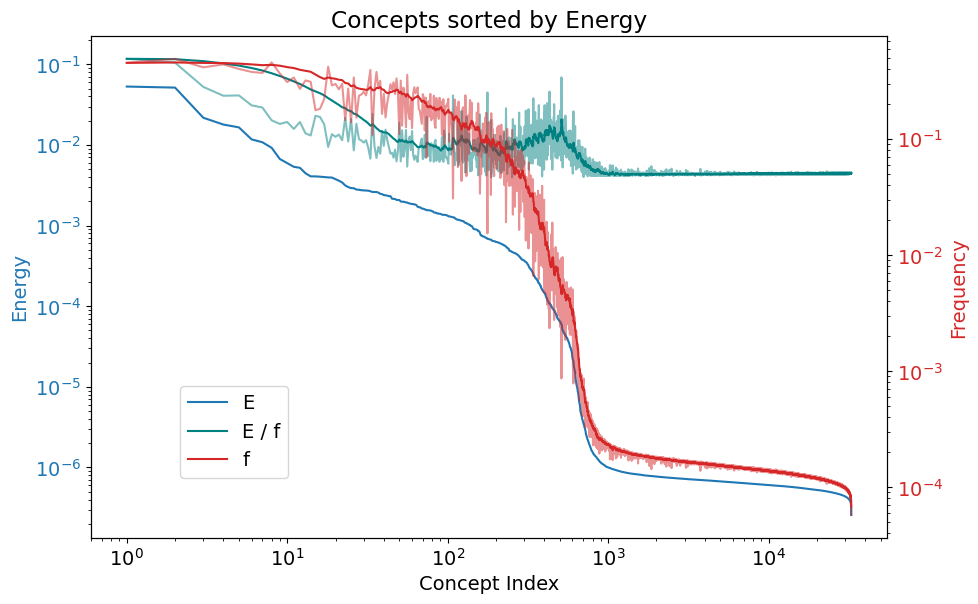

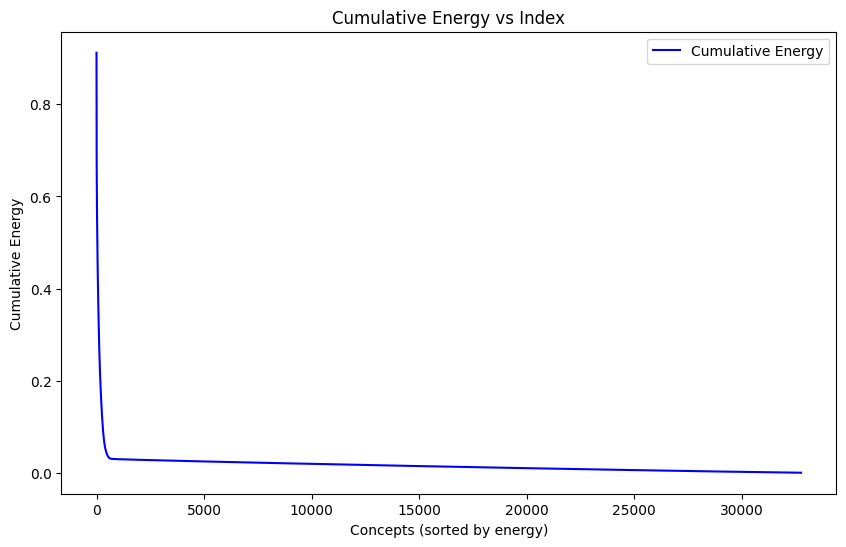

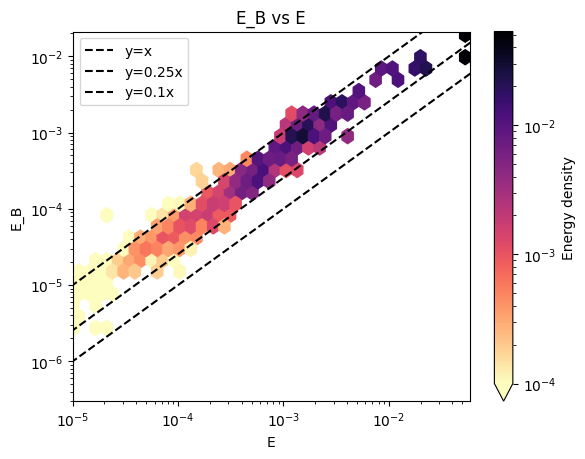

In [12]:
plot_energy(SSAE.metrics.E, SSAE.metrics.f, SSAE_name)
# plot_energy(ASAE.metrics.E, ASAE.metrics.f, ASAE_name)
plot_energy_cdf(SSAE.metrics.E, SSAE_name)
# plot_energy_cdf(ASAE.metrics.E, ASAE_name)
plot_E_vs_E_B(SSAE.metrics.E, SSAE.metrics.E_B, SSAE_name)
# plot_E_vs_E_B(ASAE.metrics.E, ASAE.metrics.E_B, ASAE_name)

## Modality Score

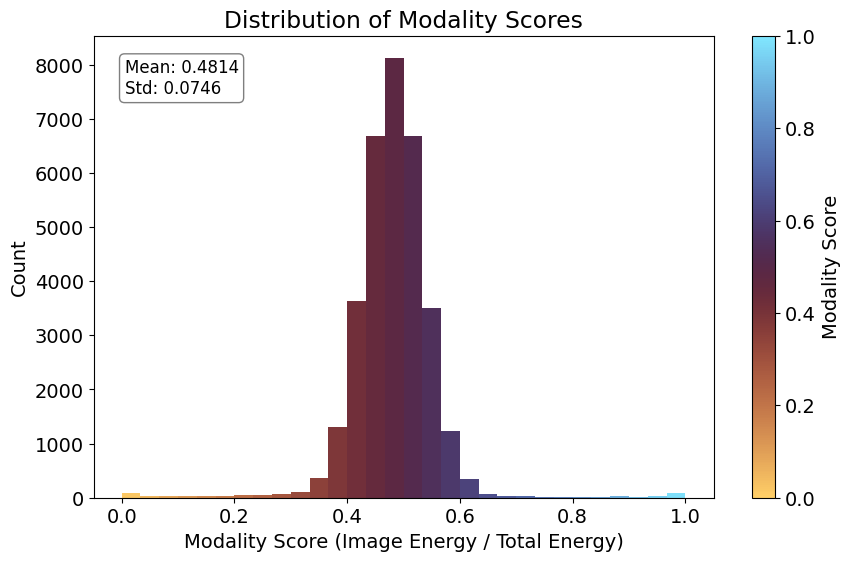

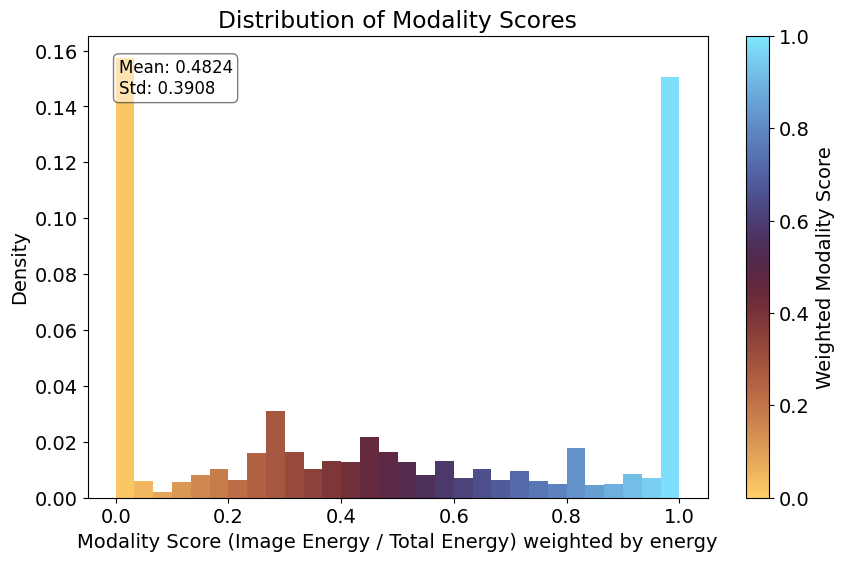

/home/gregoire.dhimoila/test/src/utils.py:2071: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins='log'
  plt.hexbin(x, y, C=((x + y) / (x + y).sum() if weighted else None), reduce_C_function=(np.sum if weighted else None), gridsize=100, bins='log', cmap='magma_r', xscale='log', yscale='log', norm=(LogNorm(vmin=max(1e-4, ((x + y) / (x + y).sum()).min())) if weighted else None))


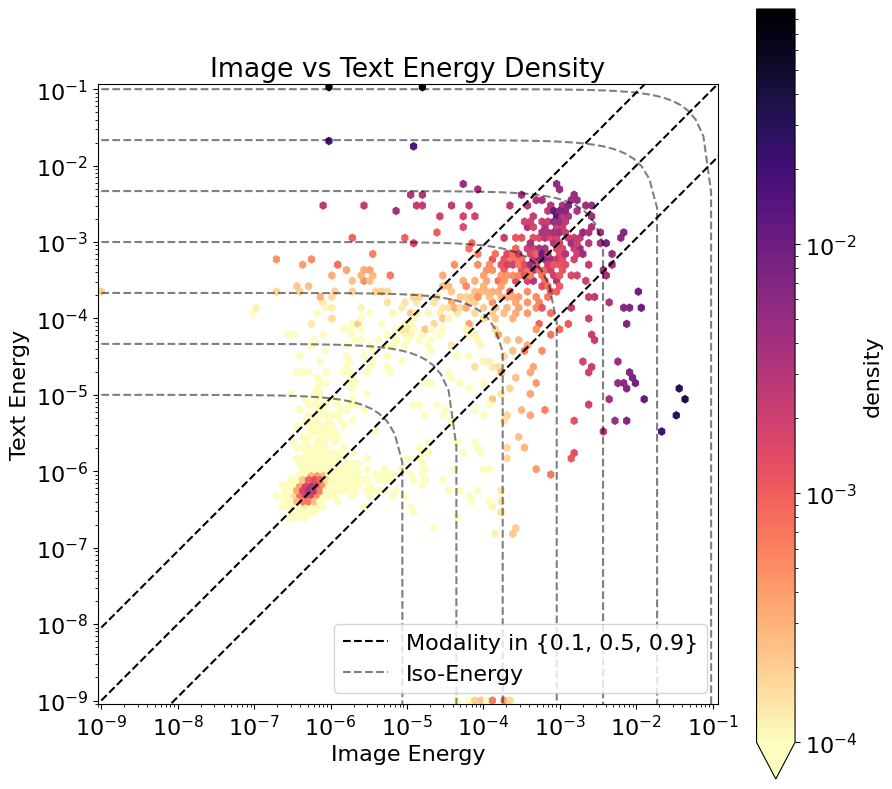

In [ ]:
plot_modality_energy(SSAE, SSAE_name)

In [14]:
# plot_modality_energy(ASAE, ASAE_name)

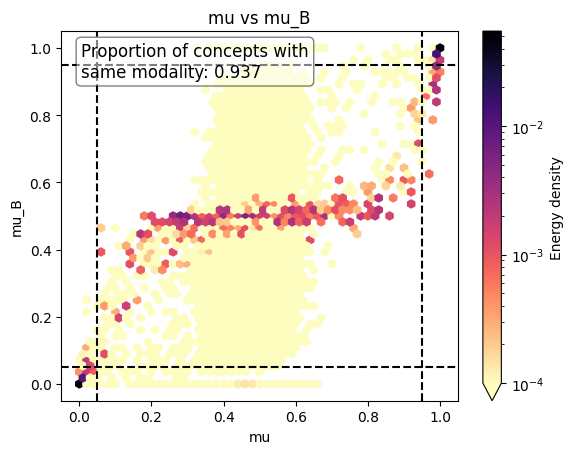

In [15]:
mu_vs_mu_B(SSAE, SSAE_name)
# mu_vs_mu_B(ASAE, ASAE_name)

In [12]:
plot_bridges(SSAE_bridge, SSAE, SSAE_name, SSAE.metrics.mu, skip_plot=True)
# plot_bridges(ASAE_bridge, ASAE, ASAE_name, ASAE.metrics.mu)

In [13]:
get_rho(SSAE, SSAE.metrics.bridge_mass_vs_eps_gamma, normalize=True)
# get_rho(ASAE, ASAE.metrics.bridge_mass_vs_eps_gamma, normalize=True)

get_rho(SSAE, SSAE.metrics.bridge_mass_vs_eps_sigma, normalize=False)
# get_rho(ASAE, ASAE.metrics.bridge_mass_vs_eps_sigma, normalize=False)

rho: 2.6905
rho: 2.5868


## General Metrics

In [14]:
get_sparse_reconstruction_metrics(SSAE, train_loader)
# get_sparse_reconstruction_metrics(ASAE, train_loader)
get_C_metrics(SSAE, train_loader, top_k=20)
# get_C_metrics(ASAE, train_loader, top_k=20)

# emd_alignment()
# SSAE.metrics._add_more(get_stability_beta(train_loader, beta=0e-4), save=True)
# ASAE.metrics._add_more(get_stability_beta(train_loader, beta=5e-4), save=True)

get_D_structure_metrics(SSAE)
# get_D_structure_metrics(ASAE)

get_Z_structure_metrics(SSAE, train_loader)
# get_Z_structure_metrics(ASAE, train_loader)

100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [03:42<00:00,  6.25it/s]


l2: 0.07686716057764068, r2: 0.9231319427490234
l0: 49.91206662888056, l1: 4.689685431620433
Dead features ratio: 0.0
Dead features %: 0.0


100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [08:12<00:00,  2.83it/s]


C_insertion: 0.5826253635440156


100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [10:06<00:00,  2.30it/s]


C_deletion: 0.15597968860767622
Stable rank: 190.99075317382812
Stable rank weighted: 1.5429619550704956
Effective rank: 492.8229675292969
Effective rank weighted: 55.1322135925293
Coherence: 0.9894377589225769


100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [05:02<00:00,  4.60it/s]


Connectivity: 0.1289084553718567
Stable rank: 2.7969949228868165
Effective rank: 596.9511108398438
Negative interference: 0.0013298686826601624


In [ ]:
# get_stability_beta(train_loader, beta=0e-4)

In [ ]:
print(SSAE.metrics)
print(ASAE.metrics)

{mu_std_arround_05: 0.4318288266658783, E_in_T: 0.3727456735559455, E_in_I: 0.30687366416651285, E_in_B: 0.32038053205396133, mu_B_std_arround_05: 0.3787815272808075, bridge_mass_vs_eps_sigma: {('T', 'T'): 0.0005648728692904115, ('T', 'B'): 0.0, ('B', 'T'): 0.010927168652415276, ('T', 'I'): 0.0, ('I', 'T'): 0.10648307204246521, ('B', 'B'): 0.08042923361063004, ('B', 'I'): 0.0, ('I', 'B'): 0.013311072252690792, ('I', 'I'): 0.0007778921280987561, 'total_mass': 0.21249331533908844, 'bad_over_good': 1.0301752052271351}, bridge_mass_vs_eps_gamma: {('T', 'T'): 0.001409673597663641, ('T', 'B'): 0.0, ('B', 'T'): 0.007185028865933418, ('T', 'I'): 0.0, ('I', 'T'): 0.1188928559422493, ('B', 'B'): 0.20595964789390564, ('B', 'I'): 0.0, ('I', 'B'): 0.006513713393360376, ('I', 'I'): 0.0012548163067549467, 'total_mass': 0.34121575951576233, 'bad_over_good': 0.553392682892233}, rho: 0.9707086667646189, l2: 0.2184677278891956, r2: 0.7815274596214294, l0: 21.15294324788435, l1: 2.654581032023237, dead: 0

NameError: name 'ASAE' is not defined

In [9]:
ws = []
ws_null = []
for archi in ["MP"]:#["ReLU", "JumpReLU", "TopK", "BatchTopK", "MP"]:
    SSAE, SSAE_name, _ = _train(beta=1e-4, train_loader=train_loader, model_name=model_name, d_model=d_model, archi=archi, device=device, top_k=50, expansion_factor=64) #, force_retrain=True, save_quand_meme=True) # Standard SAE
    SSAE.metrics = measure_everything(SSAE, train_loader, device, return_sqr=True)

    T = 10
    wasss = []
    wasserstein_nulls = []
    for i in range(T):
        SSAE2, _, _ = _train(beta=1e-4, train_loader=train_loader, model_name=model_name, d_model=d_model, archi=archi, device=device, top_k=50, expansion_factor=64, force_retrain=True)# , save_quand_meme=True) # Stand
        SSAE2.metrics = measure_everything(SSAE2, train_loader, device, return_sqr=True)
        
        metrics1 = SSAE.metrics
        metrics2 = SSAE2.metrics
        E1 = metrics1.E
        E2 = metrics2.E
        a = E1.cpu().numpy() / np.sum(E1.cpu().numpy())
        b = E2.cpu().numpy() / np.sum(E2.cpu().numpy())

        D1 = SSAE.dictionary._fused_dictionary
        D2 = SSAE2.dictionary._fused_dictionary

        wasserstein = metrics.Wasserstein(D1, D2, a, b, metric="cosim")
        wasserstein_null = metrics.Wasserstein(D1, D2, a, b[np.random.permutation(len(b))], metric="cosim")
        print(f"Wasserstein distance: {wasserstein}")
        print(f"Wasserstein distance null: {wasserstein_null}")
        wasss.append(wasserstein)
        wasserstein_nulls.append(wasserstein_null)
        
        SSAE = SSAE2
         
    wasss = np.array(wasss)
    wasserstein_nulls = np.array(wasserstein_nulls)
    ws.append((archi, wasss.mean(), wasss.std(), wasss))
    ws_null.append((archi, wasserstein_nulls.mean(), wasserstein_nulls.std(), wasserstein_nulls))


Model name: openai/clip-vit-base-patch32/laion_MP_centered_False_64_L0_50_alpha00beta00001.pt


100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [03:38<00:00,  6.38it/s]


Model name: openai/clip-vit-base-patch32/laion_MP_centered_False_64_L0_50_alpha00beta00001.pt


Epoch[1/5], L: 2.38e-04, R2: 0.87, L0: 49.7, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[1/5], Loss: 3.89e-04, R2: 0.7991, L0: 49.9418, Dead Features: 0.0%, Time: 504.1140 seconds


Epoch[2/5], L: 1.70e-04, R2: 0.91, L0: 49.7, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[2/5], Loss: 1.93e-04, R2: 0.8939, L0: 49.7691, Dead Features: 0.0%, Time: 504.1779 seconds


Epoch[3/5], L: 1.37e-04, R2: 0.92, L0: 49.6, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:23<00:00,  2.76it/s]


Epoch[3/5], Loss: 1.55e-04, R2: 0.9127, L0: 49.5372, Dead Features: 0.0%, Time: 503.8138 seconds


Epoch[4/5], L: 1.33e-04, R2: 0.92, L0: 49.5, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[4/5], Loss: 1.40e-04, R2: 0.9197, L0: 49.5231, Dead Features: 0.0%, Time: 504.1041 seconds


Epoch[5/5], L: 1.30e-04, R2: 0.92, L0: 49.5, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:23<00:00,  2.76it/s]


Epoch[5/5], Loss: 1.35e-04, R2: 0.9219, L0: 49.5160, Dead Features: 0.0%, Time: 503.9700 seconds


100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [03:39<00:00,  6.36it/s]
/home/gregoire.dhimoila/test/myenv/lib/python3.12/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Wasserstein distance: 0.34513363242149353
Wasserstein distance null: 0.32459843158721924
Model name: openai/clip-vit-base-patch32/laion_MP_centered_False_64_L0_50_alpha00beta00001.pt


Epoch[1/5], L: 2.27e-04, R2: 0.88, L0: 50.0, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[1/5], Loss: 3.85e-04, R2: 0.8013, L0: 49.9456, Dead Features: 0.0%, Time: 504.2938 seconds


Epoch[2/5], L: 1.75e-04, R2: 0.90, L0: 50.0, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:23<00:00,  2.76it/s]


Epoch[2/5], Loss: 1.89e-04, R2: 0.8964, L0: 49.9614, Dead Features: 0.0%, Time: 503.9834 seconds


Epoch[3/5], L: 1.42e-04, R2: 0.92, L0: 50.0, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[3/5], Loss: 1.45e-04, R2: 0.9159, L0: 49.9332, Dead Features: 0.0%, Time: 504.2399 seconds


Epoch[4/5], L: 1.22e-04, R2: 0.93, L0: 49.8, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:23<00:00,  2.76it/s]


Epoch[4/5], Loss: 1.31e-04, R2: 0.9218, L0: 49.9261, Dead Features: 0.0%, Time: 503.8665 seconds


Epoch[5/5], L: 1.25e-04, R2: 0.92, L0: 49.9, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[5/5], Loss: 1.28e-04, R2: 0.9236, L0: 49.9377, Dead Features: 0.0%, Time: 504.1717 seconds


100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [03:38<00:00,  6.37it/s]


Wasserstein distance: 0.3636026978492737
Wasserstein distance null: 0.2905246615409851
Model name: openai/clip-vit-base-patch32/laion_MP_centered_False_64_L0_50_alpha00beta00001.pt


Epoch[1/5], L: 2.23e-04, R2: 0.88, L0: 50.0, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:23<00:00,  2.77it/s]


Epoch[1/5], Loss: 3.87e-04, R2: 0.8003, L0: 49.9775, Dead Features: 0.0%, Time: 503.7484 seconds


Epoch[2/5], L: 1.49e-04, R2: 0.91, L0: 49.9, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[2/5], Loss: 1.88e-04, R2: 0.8966, L0: 49.9733, Dead Features: 0.0%, Time: 504.0905 seconds


Epoch[3/5], L: 1.42e-04, R2: 0.92, L0: 50.0, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[3/5], Loss: 1.44e-04, R2: 0.9160, L0: 49.9611, Dead Features: 0.0%, Time: 504.2336 seconds


Epoch[4/5], L: 1.15e-04, R2: 0.93, L0: 49.9, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[4/5], Loss: 1.31e-04, R2: 0.9219, L0: 49.9584, Dead Features: 0.0%, Time: 504.2555 seconds


Epoch[5/5], L: 1.35e-04, R2: 0.92, L0: 50.0, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:23<00:00,  2.76it/s]


Epoch[5/5], Loss: 1.27e-04, R2: 0.9237, L0: 49.9467, Dead Features: 0.0%, Time: 503.8038 seconds


100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [03:39<00:00,  6.36it/s]


Wasserstein distance: 0.2621886432170868
Wasserstein distance null: 0.30905526876449585
Model name: openai/clip-vit-base-patch32/laion_MP_centered_False_64_L0_50_alpha00beta00001.pt


Epoch[1/5], L: 4.39e-04, R2: 0.77, L0: 50.0, Dead: 0.0%:  38%|████████▊              | 536/1393 [03:13<05:10,  2.76it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch[4/5], L: 1.35e-04, R2: 0.92, L0: 49.8, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[4/5], Loss: 1.36e-04, R2: 0.9207, L0: 49.9184, Dead Features: 0.0%, Time: 504.0957 seconds


Epoch[5/5], L: 1.27e-04, R2: 0.92, L0: 49.9, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[5/5], Loss: 1.30e-04, R2: 0.9229, L0: 49.9035, Dead Features: 0.0%, Time: 504.1240 seconds


100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [03:39<00:00,  6.36it/s]


Wasserstein distance: 0.3796563148498535
Wasserstein distance null: 0.29531097412109375
Model name: openai/clip-vit-base-patch32/laion_MP_centered_False_64_L0_50_alpha00beta00001.pt


Epoch[1/5], L: 2.41e-04, R2: 0.87, L0: 49.5, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:23<00:00,  2.77it/s]


Epoch[1/5], Loss: 3.86e-04, R2: 0.8002, L0: 49.8830, Dead Features: 0.0%, Time: 503.7721 seconds


Epoch[2/5], L: 1.64e-04, R2: 0.91, L0: 49.5, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[2/5], Loss: 1.95e-04, R2: 0.8940, L0: 49.5877, Dead Features: 0.0%, Time: 504.5258 seconds


Epoch[3/5], L: 1.45e-04, R2: 0.92, L0: 49.7, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[3/5], Loss: 1.53e-04, R2: 0.9136, L0: 49.6391, Dead Features: 0.0%, Time: 504.3758 seconds


Epoch[4/5], L: 1.27e-04, R2: 0.92, L0: 49.7, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[4/5], Loss: 1.39e-04, R2: 0.9201, L0: 49.6369, Dead Features: 0.0%, Time: 504.5594 seconds


Epoch[5/5], L: 1.37e-04, R2: 0.92, L0: 49.7, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[5/5], Loss: 1.34e-04, R2: 0.9223, L0: 49.6190, Dead Features: 0.0%, Time: 504.6662 seconds


100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [03:40<00:00,  6.33it/s]


Wasserstein distance: 0.34602090716362
Wasserstein distance null: 0.321513295173645
Model name: openai/clip-vit-base-patch32/laion_MP_centered_False_64_L0_50_alpha00beta00001.pt


Epoch[1/5], L: 2.48e-04, R2: 0.87, L0: 49.6, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:26<00:00,  2.75it/s]


Epoch[1/5], Loss: 3.88e-04, R2: 0.7994, L0: 49.8732, Dead Features: 0.0%, Time: 506.2524 seconds


Epoch[2/5], L: 1.71e-04, R2: 0.91, L0: 49.6, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:26<00:00,  2.75it/s]


Epoch[2/5], Loss: 1.95e-04, R2: 0.8941, L0: 49.5615, Dead Features: 0.0%, Time: 506.3818 seconds


Epoch[3/5], L: 1.51e-04, R2: 0.92, L0: 49.6, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[3/5], Loss: 1.54e-04, R2: 0.9132, L0: 49.5815, Dead Features: 0.0%, Time: 504.6211 seconds


Epoch[4/5], L: 1.44e-04, R2: 0.92, L0: 49.6, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:25<00:00,  2.76it/s]


Epoch[4/5], Loss: 1.40e-04, R2: 0.9200, L0: 49.5901, Dead Features: 0.0%, Time: 505.0535 seconds


Epoch[5/5], L: 1.35e-04, R2: 0.92, L0: 49.6, Dead: 0.0%: 100%|██████████████████████| 1393/1393 [08:24<00:00,  2.76it/s]


Epoch[5/5], Loss: 1.35e-04, R2: 0.9221, L0: 49.6005, Dead Features: 0.0%, Time: 504.9183 seconds


100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [03:39<00:00,  6.35it/s]


Wasserstein distance: 0.2948145866394043
Wasserstein distance null: 0.3137732744216919
Model name: openai/clip-vit-base-patch32/laion_MP_centered_False_64_L0_50_alpha00beta00001.pt


Epoch[1/5], L: 5.34e-04, R2: 0.73, L0: 50.0, Dead: 0.1%:  14%|███▏                   | 190/1393 [01:08<07:15,  2.76it/s]

In [ ]:
print(SSAE.metrics)

In [10]:
for i, (archi, mean, std, wasss) in enumerate(ws):
    print(f"{archi} mean: {mean}, std: {std}")
    print(f"\tNull: {ws_null[i][1]}, std: {ws_null[i][2]}")
    # print(f"Wasss: {wasss}")

MP mean: 0.3460542857646942, std: 0.05392732098698616
	Null: 0.3085038661956787, std: 0.011064943857491016


In [8]:
for i, (archi, mean, std, wasss) in enumerate(ws):
    print(f"{archi} mean: {mean}, std: {std}")
    print(f"\tNull: {ws_null[i][1]}, std: {ws_null[i][2]}")
    # print(f"Wasss: {wasss}")

ReLU mean: 0.10521002113819122, std: 0.007753701880574226
	Null: 0.09108608216047287, std: 0.0753793865442276
JumpReLU mean: 0.34528493881225586, std: 0.016245504841208458
	Null: 0.1715255081653595, std: 0.14896972477436066
TopK mean: 0.33079034090042114, std: 0.02127441205084324
	Null: 0.13678468763828278, std: 0.014078873209655285
BatchTopK mean: 0.3565859794616699, std: 0.04681702330708504
	Null: 0.13027706742286682, std: 0.014178032986819744
MP mean: 0.256613165140152, std: 0.0037396331317722797
	Null: 0.31546857953071594, std: 0.007429171819239855
